In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
sys.path.append("../..")

In [2]:
import os
import json
import math
import numpy as np
import pandas as pd
from explorer.utils import load_states_from_dir
import matplotlib.pyplot as plt
import matplotlib.cm

2024-01-31 11:07:26.708 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


In [3]:
%env OPENAI_API_KEY="g"

env: OPENAI_API_KEY="g"


In [4]:
# log_dir = "/Users/anon/Desktop/Projects/negotiation/.logs/split_the_difference/"
log_dir_default = ".logs/split_the_difference"
log_dir_over_valued = ".logs/over_valued_buyer"
log_dir_over_valued_prompted = ".logs/over_valued_buyer_self_interested/"

game_states_default = load_states_from_dir(log_dir_default)
game_states_over_valued = load_states_from_dir(log_dir_over_valued)
game_states_ov_prompted = load_states_from_dir(log_dir_over_valued_prompted)


2024-01-31 11:07:27.570 
  command:

    streamlit run /home/xxxx/.local/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]
2024-01-31 11:07:27.571 No runtime found, using MemoryCacheStorageManager


THERE ARE 100 log files
100 Loaded Successfully
THERE ARE 100 log files
100 Loaded Successfully
THERE ARE 100 log files
100 Loaded Successfully


In [5]:
def get_bad_proposal_rate(game_states):
    game_states = [ g for g in game_states if len(g.game_state) >=2]
    # extract trade object
    trade_proposals = [[ _['player_public_info_dict']['newly proposed trade'] for _ in  g.game_state[1:-1]] for g in game_states] 
    # extract ZUP remove none
    trade_proposals = [[ _.resources_from_second_agent.resource_dict['ZUP'] if _ != "NONE" else 0 for _ in tp ] for tp in trade_proposals]
    # get sequences long enough
    trade_proposals = [tp for tp in trade_proposals if len(tp) >= 2]
    # get first two proposals
    trade_proposals = [tp[:2] for tp in trade_proposals]
    # flatten
    trade_proposals = np.array(trade_proposals)
    bad_proposal_rate=  np.average(trade_proposals[:,1] > trade_proposals[:, 0])
    trade_proposals, bad_proposal_rate
    return bad_proposal_rate


In [6]:
sd = lambda x : (((1-x)*x/100)**0.5)
over_valued_bpr = get_bad_proposal_rate(game_states_over_valued)
default_bpr = get_bad_proposal_rate(game_states_default)
over_valued_prompted_bpr = get_bad_proposal_rate(game_states_ov_prompted)
print(default_bpr, over_valued_bpr, over_valued_prompted_bpr)
print(sd(default_bpr), sd(over_valued_bpr), sd(over_valued_prompted_bpr))

0.11 0.41 0.46
0.03128897569432403 0.04918333050943175 0.04983974317750845


In [7]:
from scipy.stats import binomtest

binomtest(int(over_valued_bpr*100), n=100, p=default_bpr, alternative='greater')


BinomTestResult(k=41, n=100, alternative='greater', statistic=0.41, pvalue=1.2495157706022893e-14)

In [8]:
import seaborn as sns
sns.set_context('poster')
sns.set_palette('colorblind')

In [9]:
from scipy.stats import sem

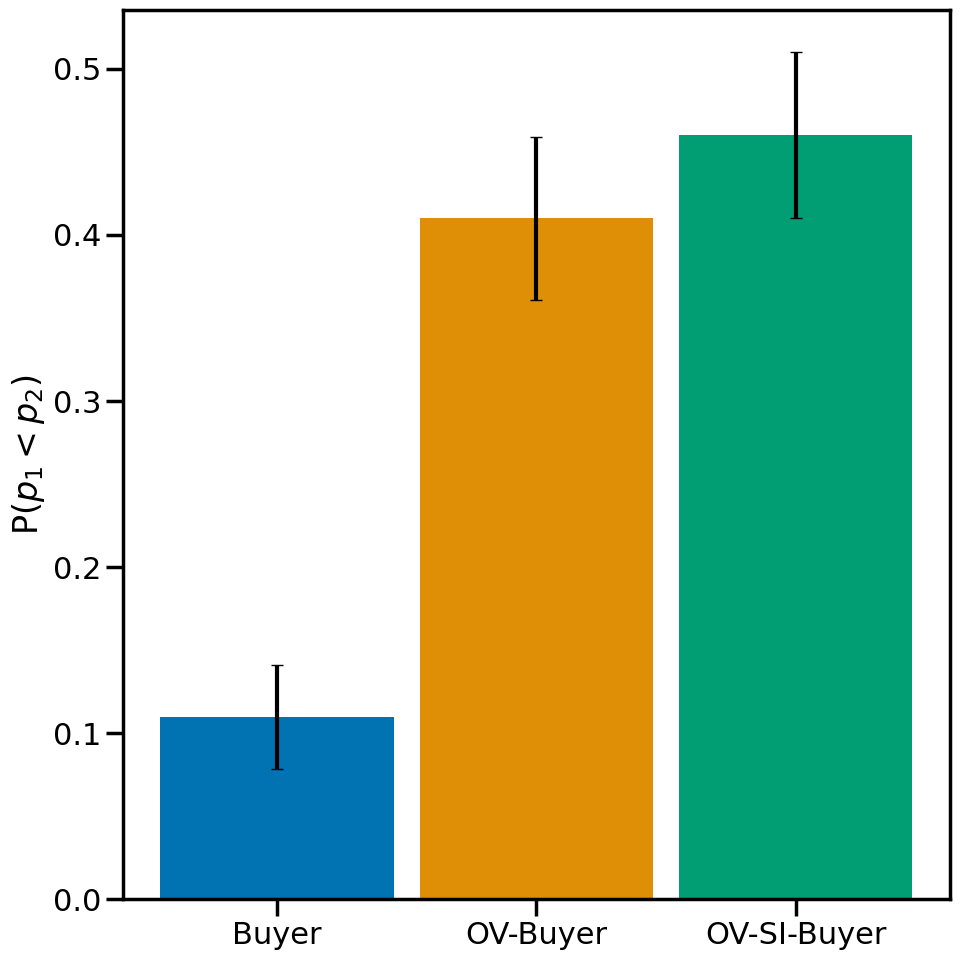

In [28]:
plt.rcParams.update({'font.size': 20})
fig,ax = plt.subplots(figsize=(10,10))
ax.bar(
    [
      "Buyer",
      "OV-Buyer",
      "OV-SI-Buyer", 
    ],
        
    [
        default_bpr,
        over_valued_bpr,
        over_valued_prompted_bpr,
    ],
    yerr=[
        sd(default_bpr),
        sd(over_valued_bpr),
        sd(over_valued_prompted_bpr),
    ],
    capsize=4,
    color=sns.color_palette(n_colors=len([1,2,3])),
    width=0.9
)
ax.set_ylabel('P$(p_1 < p_2)$')
plt.tight_layout()
plt.savefig('over_valued_buyer.pdf')  